In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw, rdFingerprintGenerator
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import rdFMCS
from rdkit.Chem import Draw

In [4]:
data = pd.read_csv("all_chem_df.csv")
data

,image_name,tags,smiles,Col3
0,pics/0,dermatologic,CC(=O)NC1C(O)OC(CO)C(O)C1O,['dermatologic']
1,pics/1,antiinfective,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,['antiinfective']
2,pics/2,antiinfective,CCCCC(C)C(=O)OC1C(C)C(CC)OC2(CC3CC(C/C=C(\C)CC...,['antiinfective']
3,pics/3,antineoplastic,COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](...,['antineoplastic']
4,pics/4,antiinfective respiratorysystem,CC(=O)N[C@@H](CS)C(=O)[O-],"['antiinfective', 'respiratorysystem']"
...,...,...,...,...
8331,pics/8331,hematologic,CC(=O)Oc1ccccc1C(=O)O.OCCN(CCO)c1nc(N2CCCCC2)c...,['hematologic']
8332,pics/8332,hematologic,C=CO.C=O,['hematologic']
8333,pics/8333,antiinfective,CC1(C)SC2[C@H](NC(=O)[C@H](N)c3ccccc3)C(=O)N2[...,['antiinfective']
8334,pics/8334,gastrointestinal,COCCCOc1ccnc(C[S@@](=O)c2nc3ccccc3[nH]2)c1C,['gastrointestinal']


In [5]:
dataReduced = data[:50]
dataReduced

,image_name,tags,smiles,Col3
0,pics/0,dermatologic,CC(=O)NC1C(O)OC(CO)C(O)C1O,['dermatologic']
1,pics/1,antiinfective,CCC[C@@]1(CCc2ccccc2)CC(O)=C([C@H](CC)c2cccc(N...,['antiinfective']
2,pics/2,antiinfective,CCCCC(C)C(=O)OC1C(C)C(CC)OC2(CC3CC(C/C=C(\C)CC...,['antiinfective']
3,pics/3,antineoplastic,COc1cc2c(c(OC)c1OC)-c1c(cc3c(c1OC)OCO3)C[C@H](...,['antineoplastic']
4,pics/4,antiinfective respiratorysystem,CC(=O)N[C@@H](CS)C(=O)[O-],"['antiinfective', 'respiratorysystem']"
5,pics/5,cns,CC(=O)OCC(=O)C1CCC2C3CCC4CC(O)CCC4(C)C3C(=O)CC12C,['cns']
6,pics/6,cns,CC(=O)Nc1nnc(S(N)(=O)=O)s1,['cns']
7,pics/7,hematologic,O=C([O-])CCC/C=C\C[C@H]1[C@H]2CC[C@H](C2)[C@@H...,['hematologic']
8,pics/8,cns,OCCN1CCN(CC/C=C2\c3ccccc3Sc3ccc(Cl)cc32)CC1,['cns']
9,pics/9,antiinfective,C[C@@H]1CCC/C=C/[C@H]2C[C@@H](O)C[C@@H]2[C@@H]...,['antiinfective']


In [6]:
compounds = []
for _, smiles in dataReduced["smiles"].items():
    compounds.append(Chem.MolFromSmiles(smiles))

In [7]:
rdkitGen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
fingerprints = [rdkitGen.GetFingerprint(mol) for mol in compounds]

In [8]:
print(f"Number of compounds converted: {len(fingerprints)}")
print(f"Fingerprint length per compound: {len(fingerprints[0])}")

Number of compounds converted: 50
Fingerprint length per compound: 1024


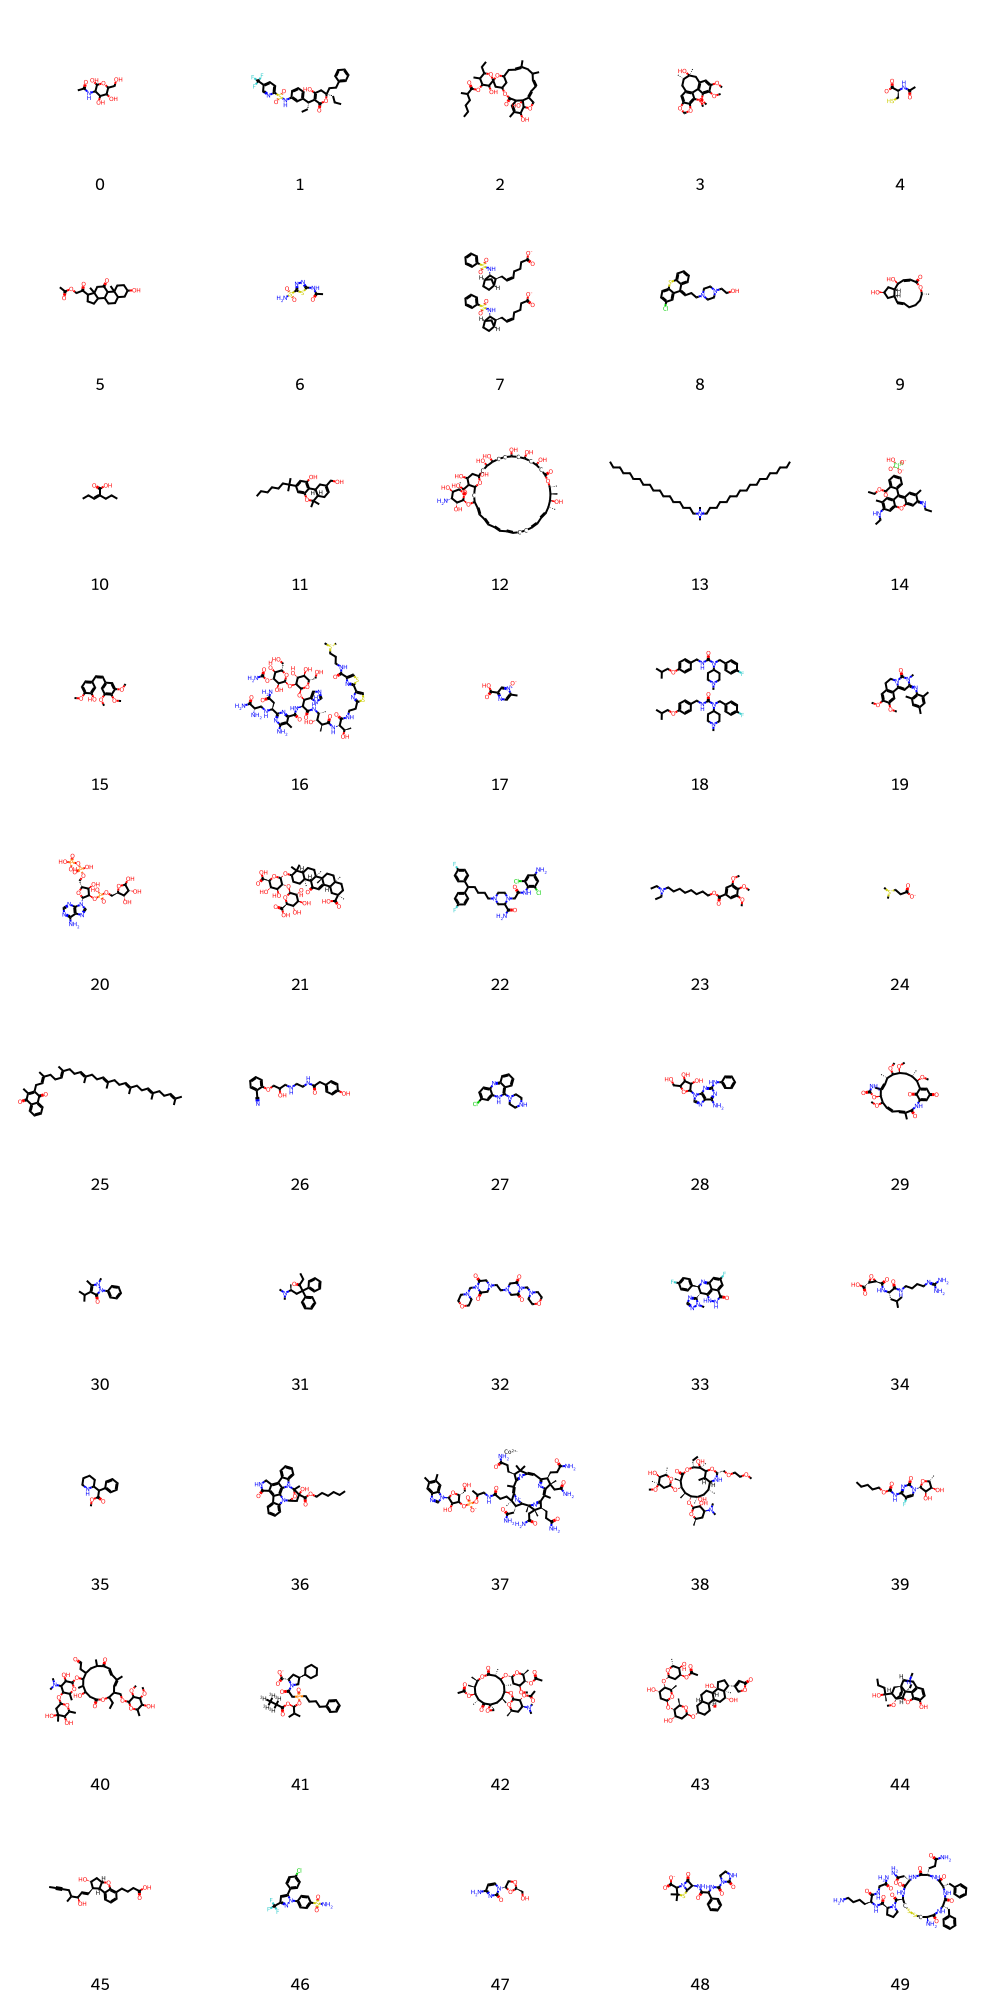

In [9]:
sample_size = 200
valid_indices = [i for i, mol in enumerate(compounds) if mol is not None][:sample_size]
legends = [str(i) for i in valid_indices]
img = Draw.MolsToGridImage(
    [compounds[i] for i in valid_indices],
    legends=legends,
    molsPerRow=5,
    subImgSize=(200, 200),
)
img

In [10]:
def tanimotoDistanceMatrix(fpList):
    """
    generate Tanimoto distance matrix
    input: list of fingerprints
    output: matrix of distances between each molecule
    """
    dissimilarityMatrix = []
    for i in range (1, len(fpList)):
        similarities = DataStructs.BulkTanimotoSimilarity(fpList[i], fpList[:i])
        dissimilarityMatrix.extend([1 - x for x in similarities])
    return dissimilarityMatrix

def clusterFingerprints(fingerprints, cutoff):
    """cluster fingerprints using Butina based on pre-set cutoff
    input: list of fingerprints, cutoff[0;1]
    output: a tuple of tuples containing information about the clusters; first element for each cluster is its centroid
    *higher cutoff = less clusters, bigger diversity within a cluster
    """
    distanceMatrix = tanimotoDistanceMatrix(fingerprints)
    clusters = Butina.ClusterData(distanceMatrix, len(fingerprints), cutoff, isDistData = True)
    clusters = sorted(clusters, key = len, reverse = True)
    return clusters

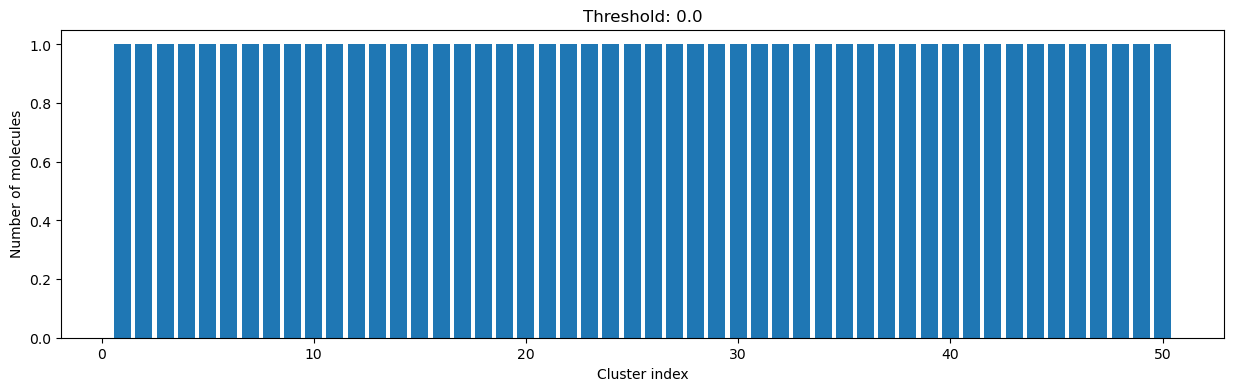

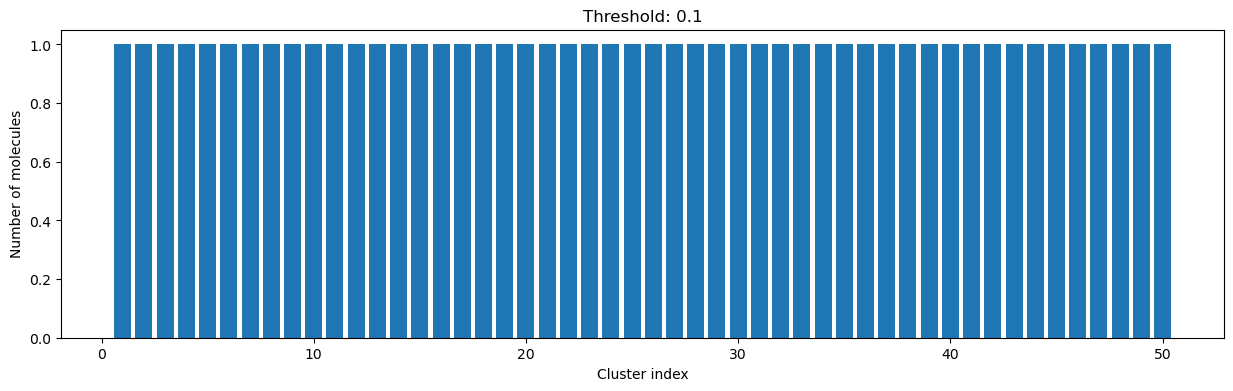

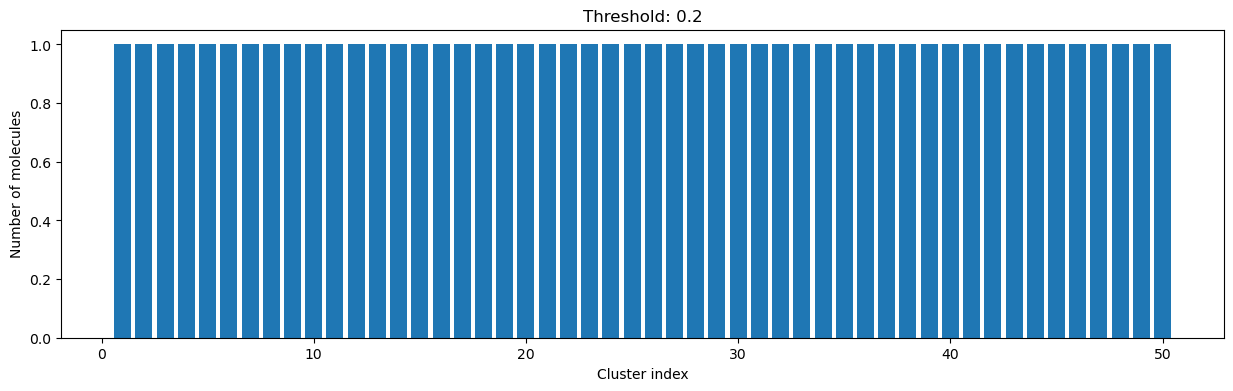

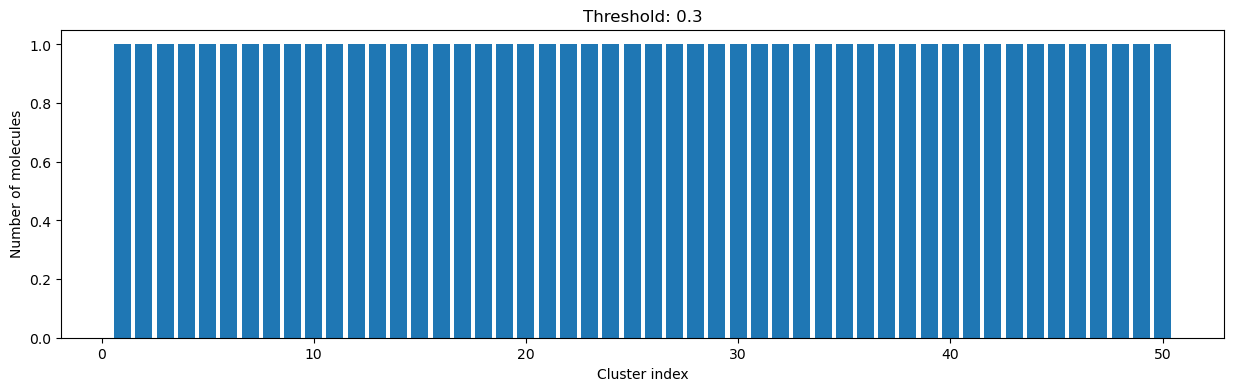

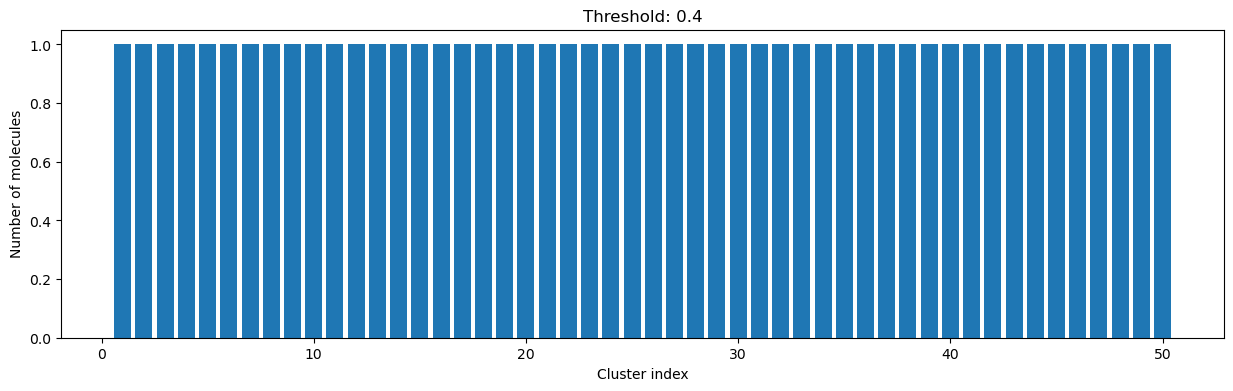

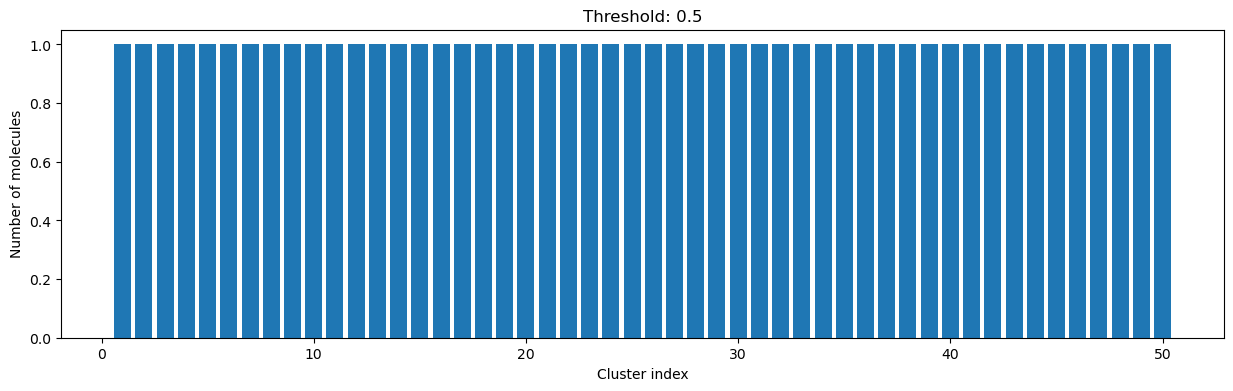

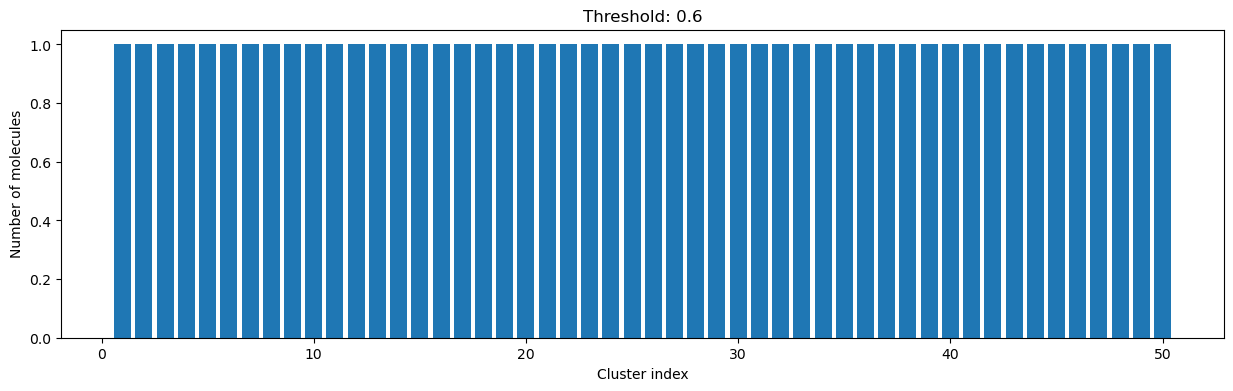

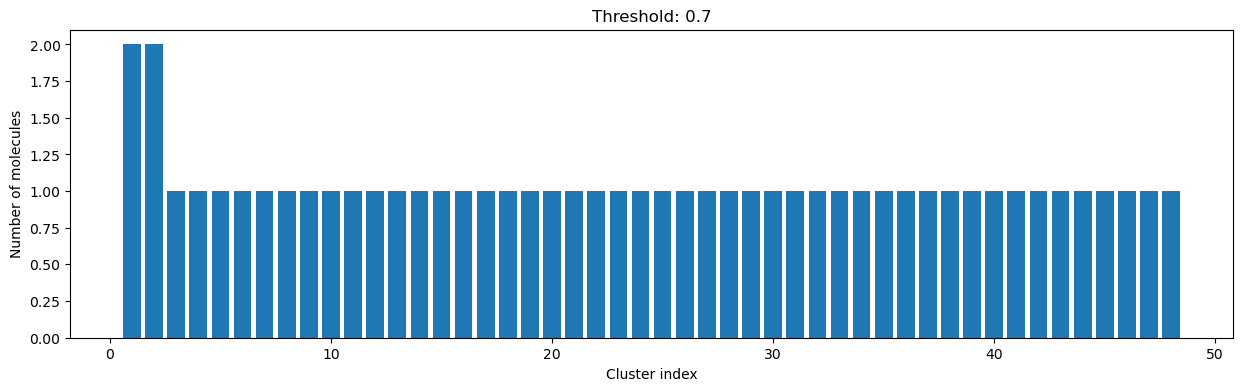

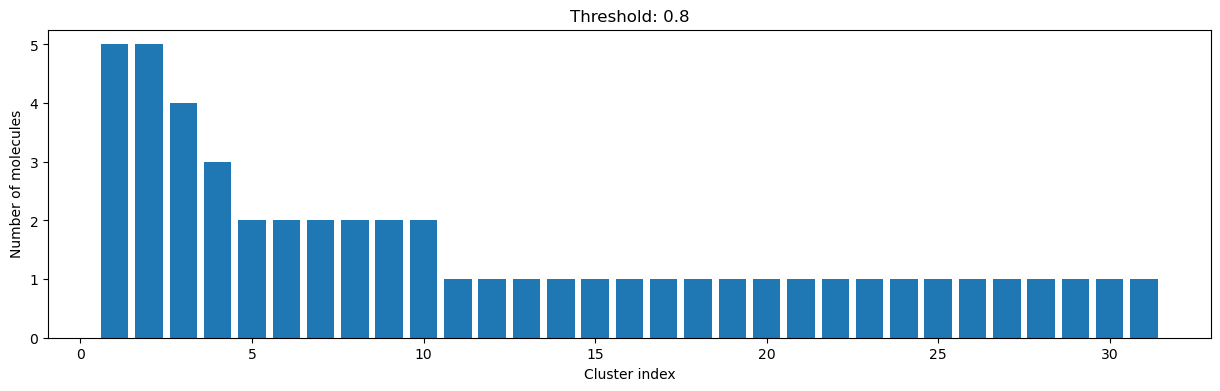

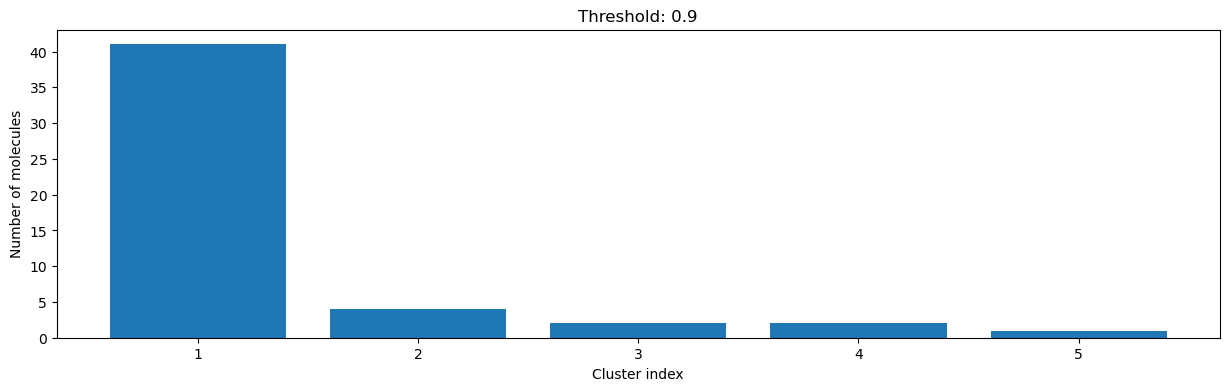

In [11]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = clusterFingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)